In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from ce_utils import load_data, one_hot, train_valid_split, random_minibatch, shuffle
from ce_utils import training_history
import time, datetime

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
neg_img, neg_name = load_data('train', 'negative', data = 'sm_core/nd')
# redspot_img, redspot_name = load_data('train', 'hemorrhagic', 'red_spot', data = 'sm_core/nd')
# angio_img, angio_name = load_data('train', 'hemorrhagic', 'angioectasia', data = 'sm_core/nd')
# active_img, active_name = load_data('train', 'hemorrhagic', 'active_bleeding', data = 'sm_core/nd')
ero_img, ero_name = load_data('train', 'depressed', 'erosion', data = 'sm_core/nd')
ulcer_img, ulcer_name = load_data('train', 'depressed', 'ulcer', data = 'sm_core/nd')
str_img, str_name = load_data('train', 'depressed', 'stricture', data = 'sm_core/nd')

In [3]:
neg_label = one_hot(neg_img, 0)
# redspot_label = one_hot(redspot_img, 1)
# angio_label = one_hot(angio_img, 1)
# active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
# print("red spot:",redspot_img.shape, redspot_label.shape)
# print("angioectasia:",angio_img.shape, angio_label.shape)
# print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (6408, 512, 512, 3) (6408, 2)
erosion: (3104, 512, 512, 3) (3104, 2)
ulcer: (3008, 512, 512, 3) (3008, 2)
stricture: (288, 512, 512, 3) (288, 2)


In [4]:
neg_train_img, neg_train_label, neg_valid_img, neg_valid_label = train_valid_split(neg_img, neg_label)
# redspot_train_img, redspot_train_label, redspot_valid_img, redspot_valid_label = train_valid_split(redspot_img, redspot_label)
# angio_train_img, angio_train_label, angio_valid_img, angio_valid_label = train_valid_split(angio_img, angio_label)
# active_train_img, active_train_label, active_valid_img, active_valid_label = train_valid_split(active_img, active_label)
ero_train_img, ero_train_label, ero_valid_img, ero_valid_label = train_valid_split(ero_img, ero_label)
ulcer_train_img, ulcer_train_label, ulcer_valid_img, ulcer_valid_label = train_valid_split(ulcer_img, ulcer_label)
str_train_img, str_train_label, str_valid_img, str_valid_label = train_valid_split(str_img, str_label)

print("negative:", neg_train_img.shape, neg_train_label.shape, neg_valid_img.shape, neg_valid_label.shape)
# print("red spot:", redspot_train_img.shape, redspot_train_label.shape, redspot_valid_img.shape, redspot_valid_label.shape)
# print("angioectasia:", angio_train_img.shape, angio_train_label.shape, angio_valid_img.shape, angio_valid_label.shape)
# print("active bleeding:", active_train_img.shape, active_train_label.shape, active_valid_img.shape, active_valid_label.shape)
print("erosion:", ero_train_img.shape, ero_train_label.shape, ero_valid_img.shape, ero_valid_label.shape)
print("ulcer:", ulcer_train_img.shape, ulcer_train_label.shape, ulcer_valid_img.shape, ulcer_valid_label.shape)
print("stricture:", str_train_img.shape, str_train_label.shape, str_valid_img.shape, str_valid_label.shape)

negative: (5447, 512, 512, 3) (5447, 2) (961, 512, 512, 3) (961, 2)
erosion: (2638, 512, 512, 3) (2638, 2) (466, 512, 512, 3) (466, 2)
ulcer: (2557, 512, 512, 3) (2557, 2) (451, 512, 512, 3) (451, 2)
stricture: (245, 512, 512, 3) (245, 2) (43, 512, 512, 3) (43, 2)


In [5]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [6]:
class CE_cnn:
    def __init__(self, k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output):
        self.k1_ch = k1_ch
        self.k2_ch = k2_ch
        self.k3_ch = k3_ch
        self.k4_ch = k4_ch
        self.k5_ch = k5_ch
        self.k6_ch = k6_ch
        self.k7_ch = k7_ch
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
    def conv_block(self, x, k_channel, maxp_name = 'maxp'):
        conv1 = tf.layers.conv2d(inputs = x, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs = conv1, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                       pool_size = [2, 2], 
                                       strides = 2,
                                       name = maxp_name)
        return maxp

    def fc2_layers(self, x, n_hidden1, n_hidden2, n_output, score_name = 'score'):
        maxp_re = tf.layers.flatten(x)
        hidden1 = tf.layers.dense(inputs = maxp_re, 
                                  units = n_hidden1,
                                  activation = tf.nn.relu)
        hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
        hidden2 = tf.layers.dense(inputs = hidden1, 
                                  units = n_hidden2,
                                  activation = tf.nn.relu)
        hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
        score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
        return score

    def inf(self, x):
        conv1 = self.conv_block(x, self.k1_ch, 'maxp1')
        conv2 = self.conv_block(conv1, self.k2_ch, 'maxp2')
        conv3 = self.conv_block(conv2, self.k3_ch, 'maxp3')
        conv4 = self.conv_block(conv3, self.k4_ch, 'maxp4')
        conv5 = self.conv_block(conv4, self.k5_ch, 'maxp5')
        conv6 = self.conv_block(conv5, self.k6_ch, 'maxp6')
        conv7 = self.conv_block(conv6, self.k7_ch, 'maxp7')

        score = self.fc2_layers(conv7, self.n_hidden1, self.n_hidden2, self.n_output, 'score')

        return score

In [7]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W0104 17:57:52.245875 140513169483520 deprecation.py:323] From <ipython-input-6-249d499180cf>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0104 17:57:52.254680 140513169483520 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0104 17:57:52.482132 140513169483520 deprecation.py:323] From <ipython-input-6-249d499180cf>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0104 17:57:52.765177 140513169483520 deprecation.py:323] F

In [8]:
LR = tf.placeholder(tf.float32)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0104 17:58:52.813114 140513169483520 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 66.67 %    || 60.00 %    || 0.56562507 || 0.64703727
--------------------------------------------------------------
[*200] || 80.00 %    || 81.67 %    || 0.52646536 || 0.53975660
--------------------------------------------------------------
[*300] || 65.00 %    || 73.33 %    || 0.58611870 || 0.55174053
--------------------------------------------------------------
[*400] || 70.00 %    || 73.33 %    || 0.53796566 || 0.50273758
--------------------------------------------------------------
[*500] || 78.33 %    || 73.33 %    || 0.42472023 || 0.50778908
--------------------------------------------------------------
[*600] || 81.67 %    || 86.67 %    || 0.35619164 || 0.29386076
--------------------------------------------------------------
[*700] || 76.67 %    || 91.67 %    || 0.42613754 || 0.26127228
--------------------------------------------------------------
[*800] || 83.33 %    || 86.67 %    || 0.37867042 || 0.31832287
-------------------------------------------------------

[6600] || 96.67 %    || 98.33 %    || 0.05822016 || 0.13759670
--------------------------------------------------------------
[6700] || 100.00 %    || 96.67 %    || 0.02356557 || 0.09765043
--------------------------------------------------------------
[6800] || 100.00 %    || 100.00 %    || 0.00115582 || 0.02696721
--------------------------------------------------------------
[6900] || 100.00 %    || 96.67 %    || 0.01144908 || 0.18378522
--------------------------------------------------------------
[7000] || 100.00 %    || 98.33 %    || 0.00491972 || 0.03120281
--------------------------------------------------------------
[7100] || 98.33 %    || 98.33 %    || 0.04145054 || 0.07128967
--------------------------------------------------------------
[7200] || 100.00 %    || 96.67 %    || 0.00584881 || 0.11449257
--------------------------------------------------------------
[7300] || 100.00 %    || 98.33 %    || 0.02115343 || 0.04508841
------------------------------------------------

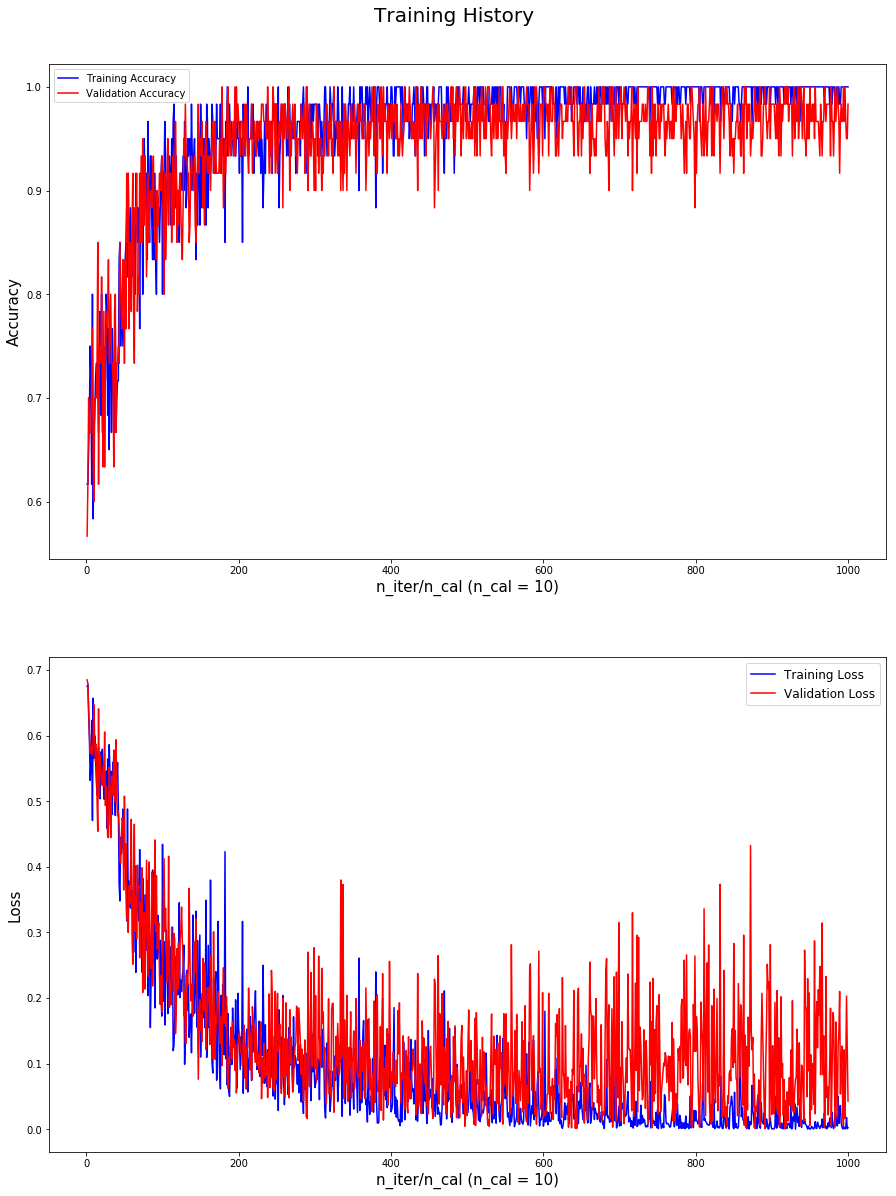

In [9]:
lr = 1e-4
n_iter = 0
n_batch = 30
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = random_minibatch(neg_train_img, neg_train_label, batch_size = n_batch)
    ero_train_x, ero_train_y = random_minibatch(ero_train_img, ero_train_label, batch_size = int(n_batch/3))
    ulcer_train_x, ulcer_train_y = random_minibatch(ulcer_train_img, ulcer_train_label, batch_size = int(n_batch/3))
    str_train_x, str_train_y = random_minibatch(str_train_img, str_train_label, batch_size = int(n_batch/3))
    train_x = np.vstack([neg_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        
        neg_valid_x, neg_valid_y = random_minibatch(neg_valid_img, neg_valid_label, batch_size = n_batch)
        ero_valid_x, ero_valid_y = random_minibatch(ero_valid_img, ero_valid_label, batch_size = int(n_batch/3))
        ulcer_valid_x, ulcer_valid_y = random_minibatch(ulcer_valid_img, ulcer_valid_label, batch_size = int(n_batch/3))
        str_valid_x, str_valid_y = random_minibatch(str_valid_img, str_valid_label, batch_size = int(n_batch/3))
        valid_x = np.vstack([neg_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_core_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 10000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[10100] || 100.00 %    || 95.00 %    || 0.00361831 || 0.08957712
--------------------------------------------------------------
[10200] || 100.00 %    || 96.67 %    || 0.00196136 || 0.05640523
--------------------------------------------------------------
[10300] || 100.00 %    || 98.33 %    || 0.00172660 || 0.09623612
--------------------------------------------------------------
[10400] || 100.00 %    || 96.67 %    || 0.00034168 || 0.05761139
--------------------------------------------------------------
[10500] || 100.00 %    || 98.33 %    || 0.00907612 || 0.03604551
--------------------------------------------------------------
[10600] || 98.33 %    || 93.33 %    || 0.01605169 || 0.30085894
--------------------------------------------------------------
[10700] || 100.00 %    || 95.00 %    || 0.00061210 || 0.13026716
--------------------------------------------------------------
[10800] || 100.00 %    || 98.33 %    || 0.

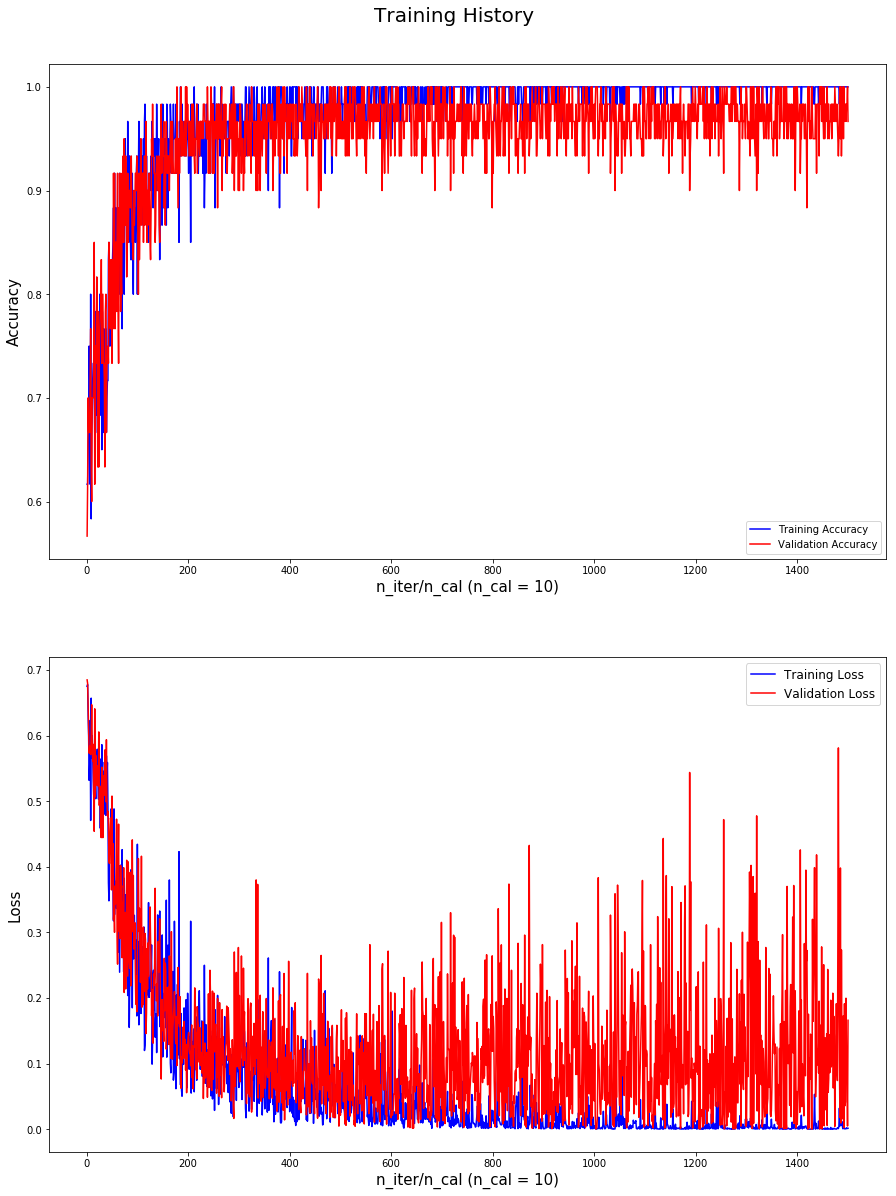

In [12]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = random_minibatch(neg_train_img, neg_train_label, batch_size = n_batch)
    ero_train_x, ero_train_y = random_minibatch(ero_train_img, ero_train_label, batch_size = int(n_batch/3))
    ulcer_train_x, ulcer_train_y = random_minibatch(ulcer_train_img, ulcer_train_label, batch_size = int(n_batch/3))
    str_train_x, str_train_y = random_minibatch(str_train_img, str_train_label, batch_size = int(n_batch/3))
    train_x = np.vstack([neg_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        
        neg_valid_x, neg_valid_y = random_minibatch(neg_valid_img, neg_valid_label, batch_size = n_batch)
        ero_valid_x, ero_valid_y = random_minibatch(ero_valid_img, ero_valid_label, batch_size = int(n_batch/3))
        ulcer_valid_x, ulcer_valid_y = random_minibatch(ulcer_valid_img, ulcer_valid_label, batch_size = int(n_batch/3))
        str_valid_x, str_valid_y = random_minibatch(str_valid_img, str_valid_label, batch_size = int(n_batch/3))
        valid_x = np.vstack([neg_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'ND_core_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 15000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()